Index(['date', 'production'], dtype='object')


<Axes: xlabel='date', ylabel='production'>

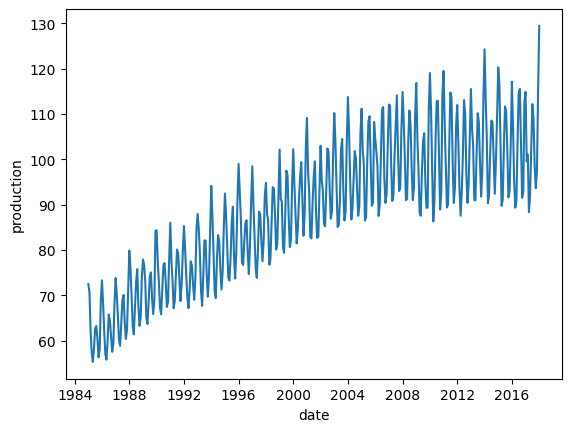

In [24]:
import numpy as np 
import pandas as pd 

import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

df = pd.read_csv('Electric_Production.csv')
df.rename(columns={'DATE':'date','IPG2211A2N':'production'},inplace=True)

df['date'] = pd.to_datetime(df['date'])

print(df.columns)

sns.lineplot(data=df,x='date',y='production')

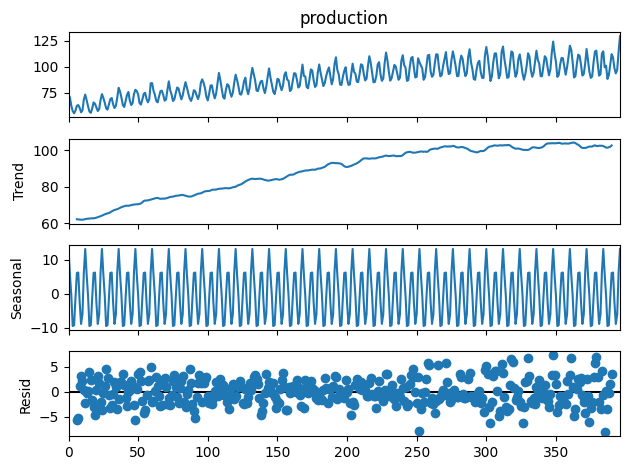

In [25]:
# Decomposing the data for better view of the data
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(x=df['production'],model='additive',period=12)
decomposition.plot()
plt.show()

# Separação treino/teste

Existem algumas formas de separar os dados para treino e teste em uma série temporal.

## Validação Temporal Simples Com Ponto Fixo
Seleciona um ponto fixo no tempo e coloca todas as observações anteriores a ele no conjunto de treino e todas as observações posteriores no conjunto de validação.
![simple split](./1.png)



In [26]:
series = pd.Series(np.random.uniform(0,1,365), index=pd.date_range('2021-01-01', '2021-12-31', freq='D'))

train = series.loc['2023-01-01':'2023-07-31']
valid = series.loc['2023-08-01':'2023-12-31']

## Validação Temporal Com Janela Deslizante


Imagine que tem um ano de dados diários e quer usar um mês para treino e um mês para validação, primeiro você treinará com os dados de Janeiro e validará com os dados de Fevereiro.

Depois você treinará com os dados de Fevereiro e validará com os dados de Março.

E assim por diante.

![windows](./2.png)


In [27]:
for date in pd.date_range('2023-02-01', '2023-12-31', freq='MS'):
    delta = date - pd.offsets.MonthBegin(1)
    train = series.loc[delta:date-pd.offsets.Day(1)]
    valid = series.loc[date:date+pd.offsets.MonthEnd(1)]

## Validação Temporal Com Janela Expansiva
No primeiro passo você treinará com os dados de Janeiro e validará com os dados de Fevereiro.

No segundo, você treinará com os dados de Janeiro e Fevereiro e validará com os dados de Março.

![windows2](./3.png)


In [29]:
for date in pd.date_range('2023-02-01', '2023-12-31', freq='MS'):
    train = series.loc[:date-pd.offsets.Day(1)]
    valid = series.loc[date:date+pd.offsets.MonthEnd(1)]

## Para o caso em específico...

In [31]:
df_test = df[['date', 'production']].loc[300:]
df_train = df[['date', 'production']].loc[:299]

# ARMA

RMSE: 6.53


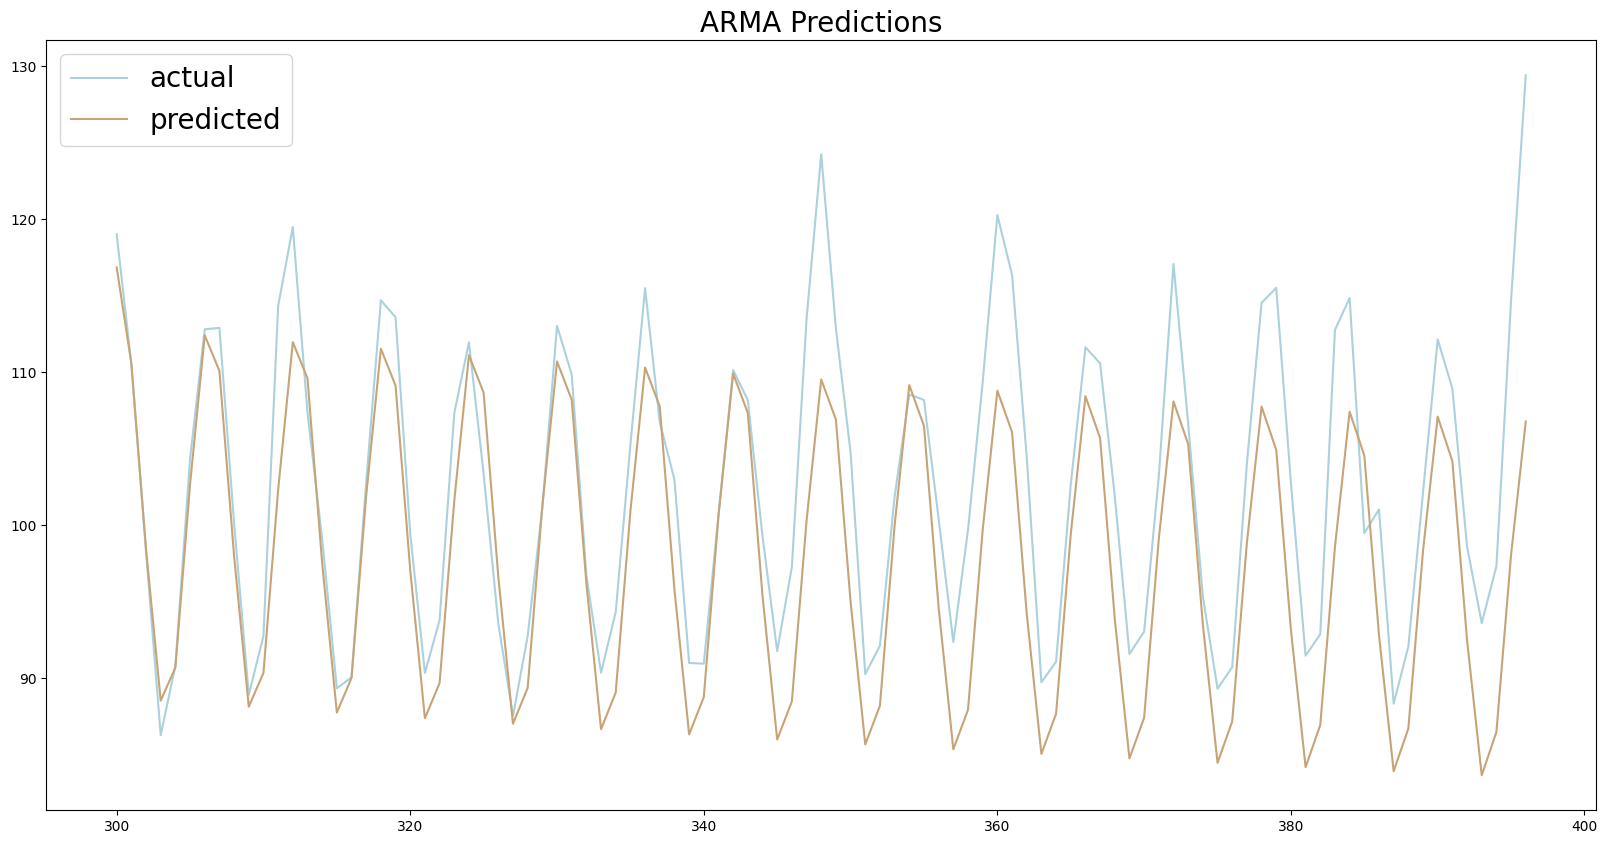

In [32]:
#ARMA(p,q)
#AR -> p -> PACF -> 3
#MA -> q -> ACF -> 4
from statsmodels.tsa.arima.model import ARIMA
ARMA_model = ARIMA(df_train['production'],order=(3,0,4)).fit(method_kwargs={"warn_convergence": False})

# generate predictions
df_pred = ARMA_model.predict(start=300, end=396)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARMA Predictions', fontsize=20)
plt.plot(df_test['production'], label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

rmse = sqrt(mean_squared_error(df_test['production'], df_pred))
print("RMSE:", round(rmse,2))


# ARIMA

RMSE: 4.35


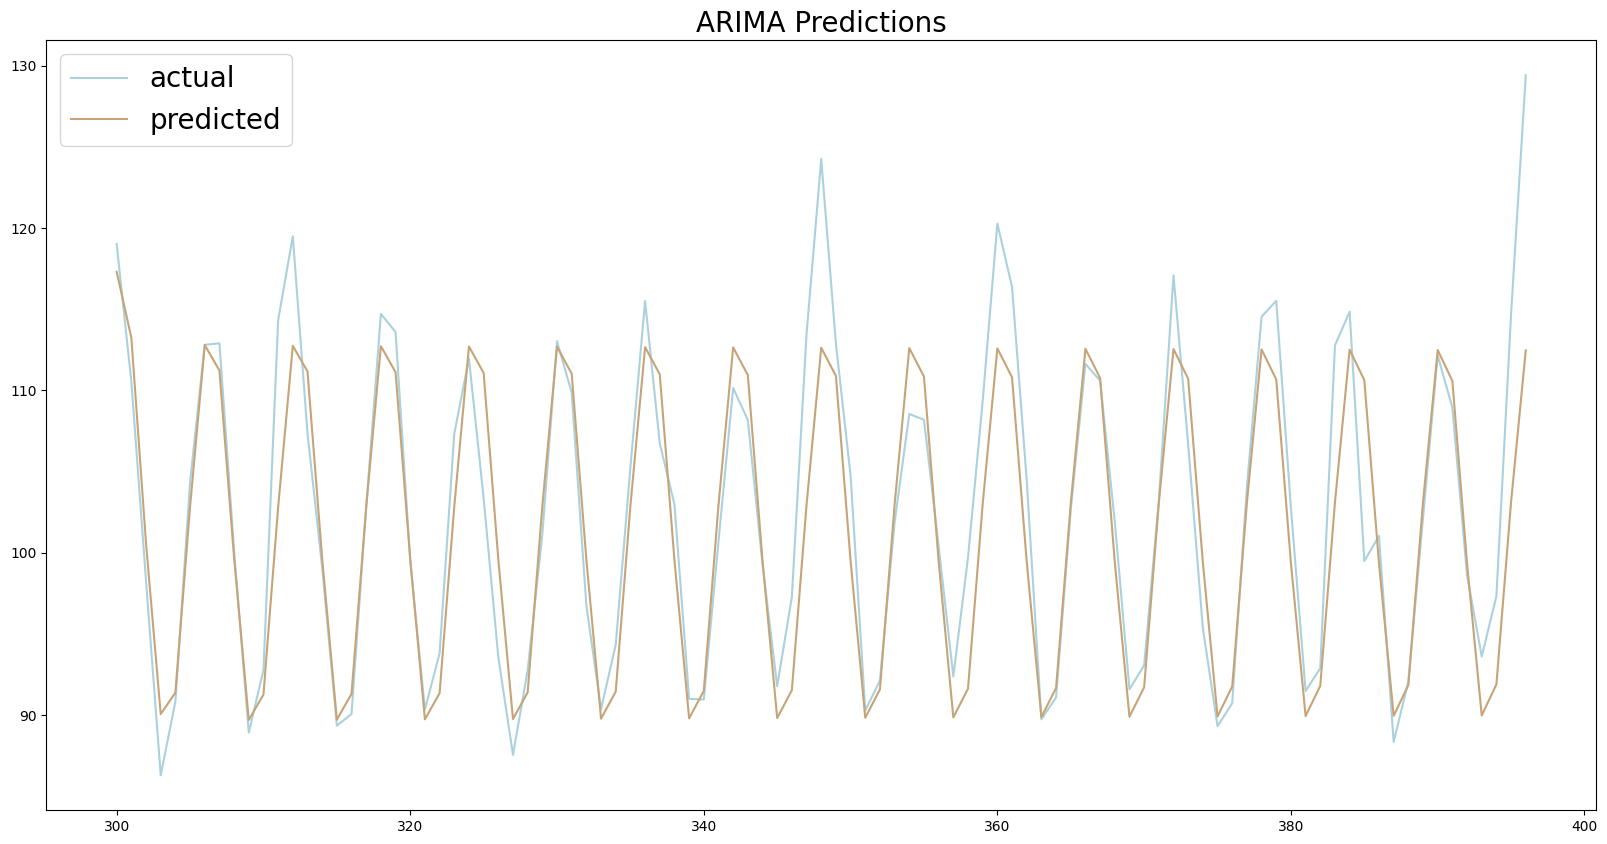

In [33]:
#ARIMA(p,d,q) ---> Address Trend
#AR -> p -> PACF -> 3
#MA -> q -> ACF -> 4
#I  -> d -> ADF after detrending -> 1
from statsmodels.tsa.arima.model import ARIMA
ARIMA_model = ARIMA(df_train['production'],order=(3,1,4)).fit(method_kwargs={"warn_convergence": False})

# generate predictions
df_pred = ARIMA_model.predict(start=300, end=396)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARIMA Predictions', fontsize=20)
plt.plot(df_test['production'], label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

rmse = sqrt(mean_squared_error(df_test['production'], df_pred))
print("RMSE:", round(rmse,2))


# SARIMA

c:\Users\ruanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 3.69


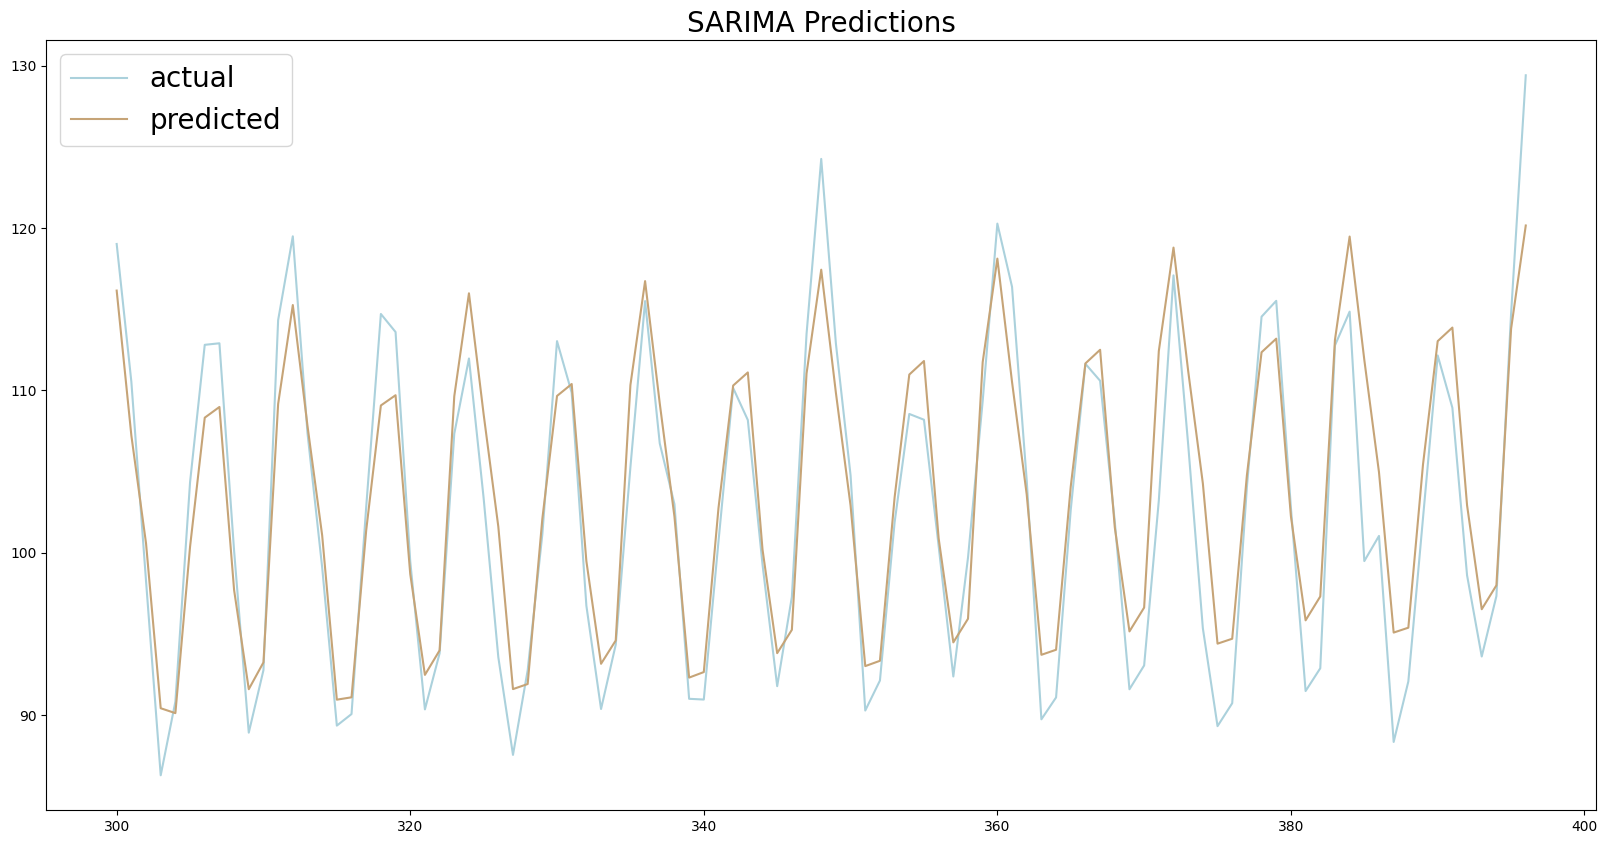

In [34]:
#SARIMAX(p,d,q)x(P,D,Q,s) ---> Address Seasonality
#AR -> p -> PACF -> 3
#MA -> q -> ACF -> 4
#I  -> d -> ADF after detrending -> 1
#AR(S) -> P -> 1
#MA(S) -> Q -> 1
#I(S) -> D -> 1
#s(S) -> s -> ACF after deseasoning -> 12
from statsmodels.tsa.statespace.sarimax import SARIMAX
SARIMA_model = SARIMAX(df_train['production'],order=(3,1,4),seasonal_order=(1, 1, 1, 12)).fit()

# generate predictions
df_pred = SARIMA_model.predict(start=300, end=396)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('SARIMA Predictions', fontsize=20)
plt.plot(df_test['production'], label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

rmse = sqrt(mean_squared_error(df_test['production'], df_pred))
print("RMSE:", round(rmse,2))